# ARIMA와 SARIMA를 통한 실제 시계열 예측


ARIMA와  SARIMA는 둘다 예측을 위한 알고리즘입니다. ARIMA 는 과거 값(자기 회귀, 이동평균)을 고려하고 이를 기반으로 미래 값을 예측합니다. SARIMA는 ARIMA와 유사하게 과거 값을 사용하지만 계절성(Seasonal) 패턴이 추가됩니다. SARIMA는 계절성을 매개변수로 사용하기 때문에 주기를 포함하는 복잡한 데이터에서 ARIMA보다 좋은 성능을 발휘할 수 있습니다.

## 예측을 위한 전처리

단순 이동평균이나 LSTM으로 모델을 예측하기 위해서는 데이터가 깨끗해야 합니다.</br>
시계열 에측 뿐 아니라 모든 데이터 분석에서는 데이터 전처리(cleaning)작업이 매우매우 중요합니다. 아래와 같은 방법으로 전처리를 진행해볼 수 있습니다.

- Detrending / Stationarity(추세제거/정상성) : 예측하기 앞서, 우리는 시계열 데이터의 평균-분산이 정상이길 바랍니다. 이는 모델의 통계적 특성이 샘플을 받아들이는 시점에 따라 달라지지 않음(정상성)을 의미합니다. 고정 데이터를 기반으로 구축된 모델이 일반적으로 더 강력합니다. 이는 차분을 통해 달성이 가능합니다.(실제로 차분을 사용해서 추세를 제거해 정상성을 찾는다고 지난번 글에 작성했습니다.)
</br>
- 이상 감지 : 데이터에 존재하는 이상치는 예측 결과를 왜곡할 여지가 있습니다. 예측하기 전 이상값을 식별하고 정규화하는 것이 좋은 방법입니다. 
</br>
- 샘플링 빈도 확인 : 샘플링의 빈도 확인은 중요한 부분 중 하나입니다. 불규칙한 샘플링은 시계열 데이터의 무결성을 깨뜨려 모델과 잘 맞지 않기 때문에 모델링 하기 전 불규칙한 데이터를 귀속시키거나 균일하게 만들 필요가 있습니다.
</br>
- 데이터 누락 : 어떠한 현상, 피치못할 사정으로 인해서 데이터 수집을 하지 못할 수 있습니다. 이 경우 모델링 전 해결을 해야만 합니다. 

## ARIMA
ARIMA(Autoregressive Integrated Moving Average), 자기 회귀 통합 이동 평균을 의미합니다. 이는 AR + I + MA가 합쳐져 ARIMA로 불립니다.

### AR(Autoregressive)
우리가 흔히 알고 있는 단일, 다중 회귀 모델에서, 목표 예상 변수의 선형 조합을 이용하여 관심 있는  변수를 예측했었습니다. AR모델에서는 해당 변수의 과거 값의 선형 결합을 사용하여 관심 변수를 예측합니다. AR(자기회귀)라는 단어는 변수 자체에 대한 회귀임을 뜻합니다. 즉, 대상 변수의 시차 값을 입력 변수로 사용하여 미래 값을 예측한다는 것입니다. 보통 자기회귀 모델은 정상성을 나타내는 데이터만 사용합니다. 차수 p의 AR모델은 다음과 같습니다.

$$y_t = c + ø_1y_{t-1} + ø_2y_{t-2} + ... + ø_py_{t-p} + ϵ_t $$

ø는 매개변수로 이 값이 바뀌면 시계열이 모형이 패턴이 변화합니다. ϵ는 오차항으로 눈의 위치가 바뀔뿐 패턴에 대한 변화는 없습니다.


위 방정식에서 현재 관측된 y 값은 과거 p 값의 선형 함수입니다.[0, p]는 학습 후 결정되는 회귀 계수 입니다. 최적의 p값을 결정하는 몇 가지 일반적인 방법이 있는데 그 중 하나가 자기 상관 및 부분 자기 상관 함수 그래프를 분석하는 것입니다.</br>
자기 상관 함수(ACF - autocorreclation funciton)는 하나의 변수의 과거와 현재 값의 상관 관계입니다. 또한 직접적인 효과와는 별도로 시간이 지남에 따른 변환 효과가 고려됩니다. 예를들어 2일전의 유가는 1일전과 오늘 가격에 영향을 줍니다. 그러나 2일전 측정한 오일가격은 ACF의 측정하는 오늘날에도 영향을 미칠 수 있습니다.</br>


부분 자기 상관 함수(PACF - Partial Autocorrelation Function)은 과거와 현재 값 간의 적접적인 상관 관계만을 측정합니다. 예를들어 PACF는 2일 전의 유가가 오늘에 미치는 영향만 측정하며 변환 효과는 없습니다.</br>

ACF와 PACF 그래프는 AR에서 p를 추론하는데 도움이 되는 과거값의 종속성을 결정하는데 도움이 됩니다.

### I(Integrated)
이 부분은 차분(differencing)에 대한 개념으로 이해하는게 가장 좋습니다. 우리가 사용하는 대부분의 시계열 데이터들은 정상성을 갖지 못한 상태입니다. 하지만 AR, MA를 사용하기 위해서는 정상성을 확보해야만 합니다. 이를 위해서 차분을 사용합니다. 차분이란 현재 상태에서 바로 이전 상태를 빼주는 것을 의미합니다. 이러한 차분의 역할로 정상성 확보를 할 수 있습니다. 다음은 차분에 대한 수식입니다.
$$d = 0 : x_t = X_t$$
$$d = 1 : x_t = X_t - X_{t-1}$$
$$d = 2 : x_t = (X_t - X_{t-1}) - (X_{t-1} - X_{t-2})$$


### MA(Moving Average)
이동 평균 모델은 회귀처럼 보이는 모델에서 과거 예측 오차를 이용합니다. 아래는 이동 평균 모델의 수식입니다.

$$y_t = c + ϵ_t + θ_1ϵ_{t-1} + θ_2ϵ_{t-2} + ... + θ_qϵ_{t-q}$$

$ϵ$은 백색잡음이라고 하며 모델과 대상 변수 사이의 임의 잔차 편차를 나타냅니다. $ϵ$은 모델을 피팅한 후에만 결정할 수 있고 매개변수이기도 하기 때문에 **관찰 할 수 없는 매개변수**입니다. 따라서 MA 수식을 풀기 위해서 OLS 대신 Maximum Likelihood Estimation과 같은 반복 기법이 사용됩니다.


### ARIMA 구현하기(Python)
[사용 데이터셋](https://www.kaggle.com/datasets/yekahaaagayeham/time-series-toy-data-set)

데이터 전처리 과정은 분석가의 주관이 들어가기 때문에 각기 다른 전처리 과정이  이뤄집니다. 이 점을 항상 생각해주세요!

In [13]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0) # 동일한 결과로 코드를 재현하기 위한 시드 설정


Text(0, 0.5, 'Sales')

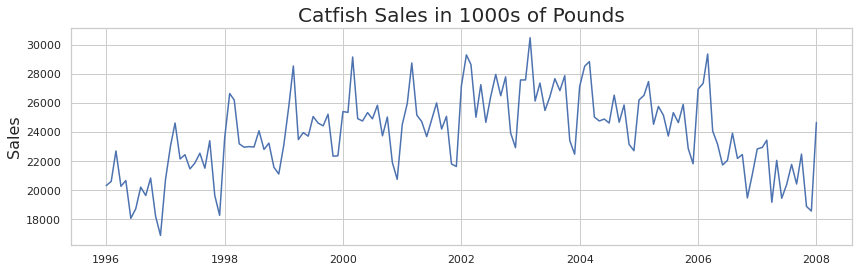

In [4]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')
#read data
catfish_sales = pd.read_csv('/content/drive/MyDrive/ds_study/Time_Series/ARIMA/catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

#transform
start_date = datetime(1996,1,1)
end_date = datetime(2008,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

#plot
plt.figure(figsize=(14,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)


데이터를 보면 분명한 추세와 계절성이 있음이 보입니다. 이를 STL분해를 해보겠습니다.

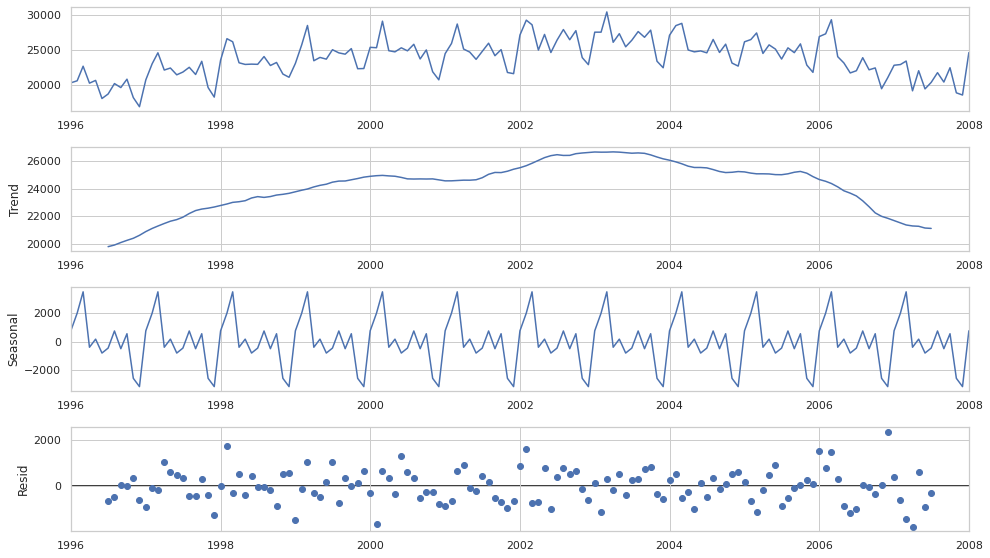

In [5]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(lim_catfish_sales,model='additive')
fig = result.plot()

시계열 분해를 통해 생각해 볼 수 있는 사항
- 6월, 12월의 계절 패턴이 보입니다.
- 상승과 하락의 추세는 뚜렷합니다.

이제 p와q값을 결정을 위한 정보를 얻기 위해 ACF와 PACF를 살펴보겠습니다.

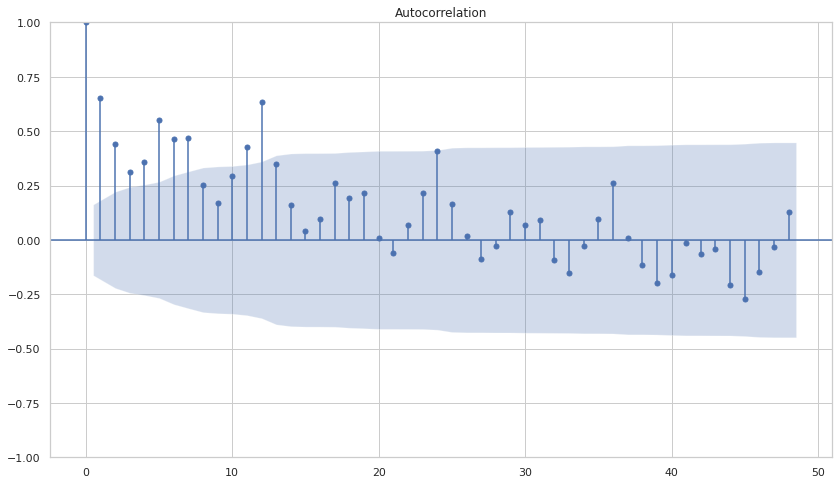

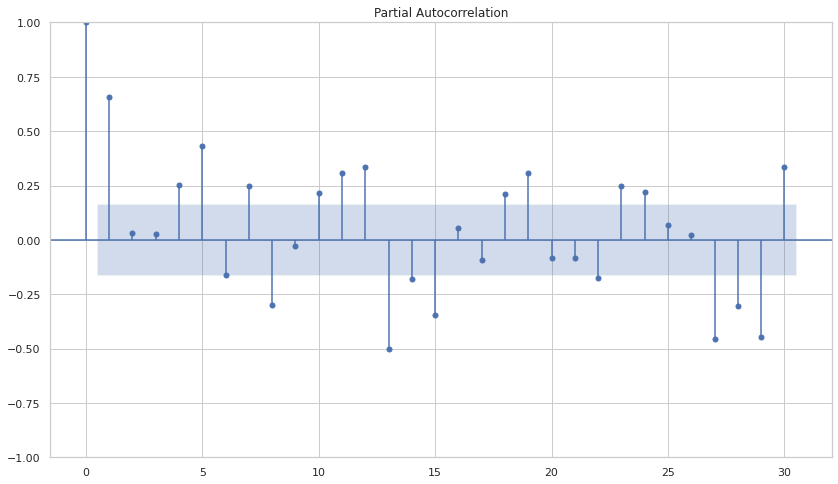

In [6]:
plot_acf(lim_catfish_sales['Total'], lags=48);
plot_pacf(lim_catfish_sales['Total'], lags=30);

ACF / PACF를 통해 생각해볼 수 있는 사항
- ACF에서 6월, 12월에 상당한 변화가 있습니다.(상관이 크게 증가한 부분들을 보면 6월 혹은 12월인 것을 알 수 있습니다.
- PACF는 정현파(주기 함수)로 보입니다.

이를 통해서 추세는 명확하지만 정상성이 확보되지 않아기에 차분 d는 1로, p값은 6과 12로 테스트 해볼 수 있습니다.
</br></br>

**ARIMA**

In [23]:
# 아리마의 매개변수는 (p,d,q)를 사용합니다. 이를 순서대로 넣어줍니다.
arima = ARIMA(lim_catfish_sales['Total'], order=(6,1,1))
predictions = arima.fit().predict()

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(lim_catfish_sales.diff(), label="Actual")
plt.plot(predictions.diff(), label="Predicted")
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

![img](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Arima-comparative-plot.png?ssl=1)


예측 값이 일부 peak(꼭지점)을 따라잡지 못했지만 데이터의 본질(흐름)을 잘 포착한 것이 볼 수 있습니다. 모델의 성능을 개선을 위해서는 더 다양한 (p,d,q)으로 변경하여 실험해 볼 수 있습니다. 이를 위한 방법 중 한 가지인 Auto-ARIMA를 사용할 수도 있습니다. 이는 무거운 작업을 수행하고 하이퍼 파라미터 튜닝합니다.</br></br>

**SARIMA**
SARIMA(Seasonal-ARIMA)로 기존 ARIMA에 계절성에 대한 정보까지 다루는 모델입니다. SARIMA의 모델은 다음과 같이 표현됩니다.

![img](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Sarima-seasonality.png?ssl=1)

</br>
ARIMA와 같은 p,d,q를 사용ㅎ자미나 대분자인 P,D,Q그리고 연간 관측 횟수를 나타내는 m으로 표현하게 됩니다. ARIMA와 마찬가지로 ACF, PACF를 통해서 P,D,Q값을 추론해 볼 수 있습니다.

In [25]:
sarima = SARIMAX(lim_catfish_sales['Total'],
                order=(1,1,1), # 비계절성 부분
                seasonal_order=(1,1,0,6)) # 계절성 부분
predictions = sarima.fit().predict()

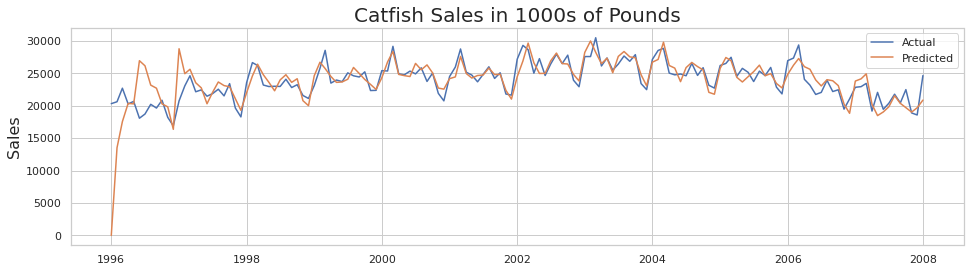

In [26]:
plt.figure(figsize=(16,4))
plt.plot(lim_catfish_sales, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

시작에는 원본 데이터에 대한 예측이 좋지 못했지만 금방 올바른 예측으로 돌아가고 그 예측이 ARIMA보다 좋다는 것이 눈에 보입니다. 


### ARIMA와 SARIMA 모델의 장단점

**장점**
- 쉬운 이해와 해석</br>
ARIMA 기반의 모델은 모델의 단순성과 해석 가능성입니다. 결과의 품질을 유지하면서 이 두가지에 집중한다면 관계자와의 커뮤니케이션에 도움이 될 것입니다.</br></br>

- 제한된 변수</br>
하이퍼 파라미터가 적기 때문에 모델이 프로덕션에 들어가는 경우 구성 파일을 쉽게 유지 관리 할 수 있습니다.
</br></br>

**단점**

- 기하급수적인 시간복잡도</br>
p와 q의 값이 증가하면 더 많은 계수가 필요하게 되므로 이 두 값이 증가하면 시간복잡도 역시 증가하게됩니다. 이러한 점이 Prophet과 같은 비지니스 분야에서의 예측 모델 탄생 배경의 이유이기도 합니다. </br></br>
- 복잡한 데이터</br>
데이터가 너무 복잡하고 p와 q에 대한 최적 솔루션이 없을 가능성이 없지 않습니다. 물론 ARIMA기반의 모델이 실패할 가능성은 낮지만 만약 발생한다면 불행하게도 다른 방법을 찾아봐야할 것입니다.</br></br>
- 필요한 데이터의 양</br>
데이터가 계절성이 있는 데이터라면 특히나 많은양의 데이터가 필요합니다. 예를 들어 2~3년에 대한 과거 수요를 사용하는 것은 좋은 예측 모델을 만들어내기 힘들다는 뜻 입니다.


### ARIMA 기반 모델을 사용한 논문

[인도의 코로나 역학 예측 with ARIMA](https://journals.sagepub.com/doi/full/10.1177/0972150920988653)

</br>

[일일 및 월간 평균 서울의 태양복사량 예측 with ARIMA](https://www.mdpi.com/2073-8994/11/2/240)

</br>

[ARIMA 모델을 통한 질병관리](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4872983/)

</br>

[ARIMA 모델을 통한 수요 예측](https://journals.sagepub.com/doi/full/10.1177/1847979018808673)

